In [ ]:
# MARCH 2025 - calculate floodd and potential DFs for mustang to make a bubble plot 

In [131]:
# Filter the DataFrame for the specified date range


start_date = "1990-08-31"
end_date = "2021-06-30"


def filter_by_date(df, start_date = start_date, end_date = end_date, date_column='D'):
    """
    Filters a DataFrame to include only rows where the date_column is within the given range.

    Parameters:
        df (pd.DataFrame): The input DataFrame.
        start_date (str or pd.Timestamp): The start date (inclusive).
        end_date (str or pd.Timestamp): The end date (inclusive).
        date_column (str): The column containing date values (default is 'D').

    Returns:
        pd.DataFrame: The filtered DataFrame.
    """
    df[date_column] = pd.to_datetime(df[date_column])  # Convert to datetime
    return df[(df[date_column] >= start_date) & (df[date_column] <= end_date)]



'''

def prepare_dfcount(dfcount):
    dfcount['D'] = pd.to_datetime(dfcount['D'])
    
    dfcount = dfcount.drop('D', axis=1)
    dfcount = dfcount.rename(columns={'D_year': 'year', 'D_month': 'month'})
    
    # Melt the dataframe
    melted = pd.melt(dfcount, id_vars=['year', 'month'], var_name='elevation', value_name='dfs_count')
    
    # Process elevation column
    melted['elevation'] = melted['elevation'].str.split('.').str[0].astype(float)

df[['base', 'suffix']] = df['elevation'].astype(str).str.extract(r'(\d+)(?:\.\d+)?(?:\.(\d+))?')
df['base'] = df['base'].astype(int)
df['suffix'] = df['suffix'].fillna(0).astype(int)
df['elevation'] = df['base'] + df['suffix']

    
    melted['elevation_bin'] = melted.apply(functions.bin_elevation500, axis=1)
    
    # Create unique id for elevation and month for merging
    melted['elevation'] = melted['elevation'].astype(int)
    melted['id'] = melted.index.astype(str) + "_" + melted['elevation'].astype(str) + "_" + melted['year'].astype(str) + "_" + melted['month'].astype(str)
    # melted['id'] = melted['elevation'].astype(str) + "_" + melted['year'].astype(str) + "_" + melted['month'].astype(str)
    
    return melted
'''

def prepare_dfcount(dfcount):
    dfcount['D'] = pd.to_datetime(dfcount['D'])
    
    dfcount = dfcount.drop('D', axis=1)
    dfcount = dfcount.rename(columns={'D_year': 'year', 'D_month': 'month'})
    
    # Melt the dataframe
    melted = pd.melt(dfcount, id_vars=['year', 'month'], var_name='elevation', value_name='dfs_count')
    
    # Process elevation column
    melted[['base', 'suffix']] = melted['elevation'].astype(str).str.extract(r'(\d+)(?:\.\d+)?(?:\.(\d+))?')
    melted['base'] = melted['base'].astype(int)
    melted['suffix'] = melted['suffix'].fillna(0).astype(int)
    melted['elevation'] = melted['base'] + melted['suffix']*10
    melted['elevation'] = melted['elevation'].astype(float)


    
    melted['elevation_bin'] = melted.apply(functions.bin_elevation500, axis=1)
    
    # Create unique id for elevation and month for merging
    melted['elevation'] = melted['elevation'].astype(int)
    # melted['id'] = melted.index.astype(str) + "_" + melted['elevation'].astype(str) + "_" + melted['year'].astype(str) + "_" + melted['month'].astype(str)
    melted['id'] = melted['elevation'].astype(str) + "_" + melted['year'].astype(str) + "_" + melted['month'].astype(str)
    
    return melted







def calculate_floods(df):
    # df percent 
    df[f'dfs_count_60_percent'] = (df[f'dfs_count_60percent'] *100) / df.dfspot_count
    df[f'dfs_count_50_percent'] = (df[f'dfs_count_50percent'] *100) / df.dfspot_count
    df[f'dfs_count_40_percent'] = (df[f'dfs_count_40percent'] *100) / df.dfspot_count
    df[f'dfs_count_30_percent'] = (df[f'dfs_count_30percent'] *100) / df.dfspot_count
    df[f'dfs_count_20_percent'] = (df[f'dfs_count_20percent'] *100) / df.dfspot_count
    # ff count 
    df[f'ffs_count_60'] = df.dfspot_count - df[f'dfs_count_60percent']
    df[f'ffs_count_50'] = df.dfspot_count - df[f'dfs_count_50percent']
    df[f'ffs_count_40'] = df.dfspot_count - df[f'dfs_count_40percent']
    df[f'ffs_count_30'] = df.dfspot_count - df[f'dfs_count_30percent']
    df[f'ffs_count_20'] = df.dfspot_count - df[f'dfs_count_20percent']
    # ff percent
    df[f'ffs_count_60_percent'] = (df[f'ffs_count_60'] *100) / df.dfspot_count
    df[f'ffs_count_50_percent'] = (df[f'ffs_count_50'] *100) / df.dfspot_count
    df[f'ffs_count_40_percent'] = (df[f'ffs_count_40'] *100) / df.dfspot_count
    df[f'ffs_count_30_percent'] = (df[f'ffs_count_30'] *100) / df.dfspot_count
    df[f'ffs_count_20_percent'] = (df[f'ffs_count_20'] *100) / df.dfspot_count
    return df



def merge_landcover_dfs(dfs, dfspot, merge_on, dfspot_column):
    """
    Merges a list of dataframes on specified columns and adds a column from a 'dfspot' dataframe.
    
    Parameters:
        dfs (list of pd.DataFrame): List of dataframes to merge sequentially.
        dfspot (pd.DataFrame): A dataframe containing a column to add after the merges.
        merge_on (list of str): Columns to use as the merge keys.
        dfspot_column (str): The name of the column in `dfspot` to add after merging.
        
    Returns:
        pd.DataFrame: The merged dataframe with the additional column from `dfspot`.
    """
    
    # Start with the first dataframe in `dfs` and automatically get the count column
    count_column = [col for col in dfs[0].columns if col.startswith('dfs_count')][0]
    merged_df = dfs[0][merge_on + [count_column]]
    
    # Iterate over remaining dataframes and merge each sequentially
    for df in dfs[1:]:
        count_column = [col for col in df.columns if col.startswith('dfs_count')][0]
        merged_df = pd.merge(merged_df, df[merge_on + [count_column]], on=merge_on)
    
    # Add the `dfspot_column` from `dfspot` dataframe to the merged dataframe
    merged_df['dfspot_count'] = dfspot[dfspot_column]
    
    return merged_df


In [132]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import glob

import functions

In [133]:
# 1 dfspot
location = 'mustang'

path = '/Users/varyabazilova/Desktop/paper2/202406_modelruns/30years/2025Jan_output/TL/march2025test2/'

dfspot1_df = pd.read_csv(path + f'mustang_monthly_dfspot_count_20percent_landcover1.csv', index_col = 0).fillna(0)
dfspot2_df = pd.read_csv(path + f'mustang_monthly_dfspot_count_20percent_landcover2.csv', index_col = 0).fillna(0)
dfspot3_df = pd.read_csv(path + f'mustang_monthly_dfspot_count_20percent_landcover3.csv', index_col = 0).fillna(0)
dfspot4_df = pd.read_csv(path + f'mustang_monthly_dfspot_count_20percent_landcover4.csv', index_col = 0).fillna(0)
dfspot5_df = pd.read_csv(path + f'mustang_monthly_dfspot_count_20percent_landcover5.csv', index_col = 0).fillna(0)


dfspot1_df = filter_by_date(dfspot1_df)
dfspot2_df = filter_by_date(dfspot2_df)
dfspot3_df = filter_by_date(dfspot3_df)
dfspot4_df = filter_by_date(dfspot4_df)
dfspot5_df = filter_by_date(dfspot5_df)

dfspot1 = prepare_dfcount(dfspot1_df).fillna(0)
dfspot2 = prepare_dfcount(dfspot2_df).fillna(0)
dfspot3 = prepare_dfcount(dfspot3_df).fillna(0)
dfspot4 = prepare_dfcount(dfspot4_df).fillna(0)
dfspot5 = prepare_dfcount(dfspot5_df).fillna(0)


# dfspot1['landcover'] = 'langcover 1'
# dfspot2['landcover'] = 'langcover 2'
# dfspot3['landcover'] = 'langcover 3'
# dfspot4['landcover'] = 'langcover 4'
# dfspot5['landcover'] = 'langcover 5'

In [134]:
dfspot5_df

,D,3689.0,2546.0,3964.0,2571.0,2886.0,3795.0,3540.0,4420.0,5534.0,...,4439.0,4593.0,4603.0,4733.0,4905.0,4952.0,4812.0,4889.0,D_year,D_month
11,1990-08-31,3,3,3,3,3,3,3,3,0,...,0,0,0,0,0,0,0,0,1990,8
12,1990-09-30,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1990,9
13,1990-10-31,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1990,10
14,1990-11-30,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1990,11
15,1990-12-31,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1990,12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
377,2021-02-28,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,2021,2
378,2021-03-31,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,2021,3
379,2021-04-30,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,2021,4
380,2021-05-31,1,1,1,1,1,1,1,2,0,...,0,0,0,0,0,0,0,0,2021,5


<AxesSubplot:>

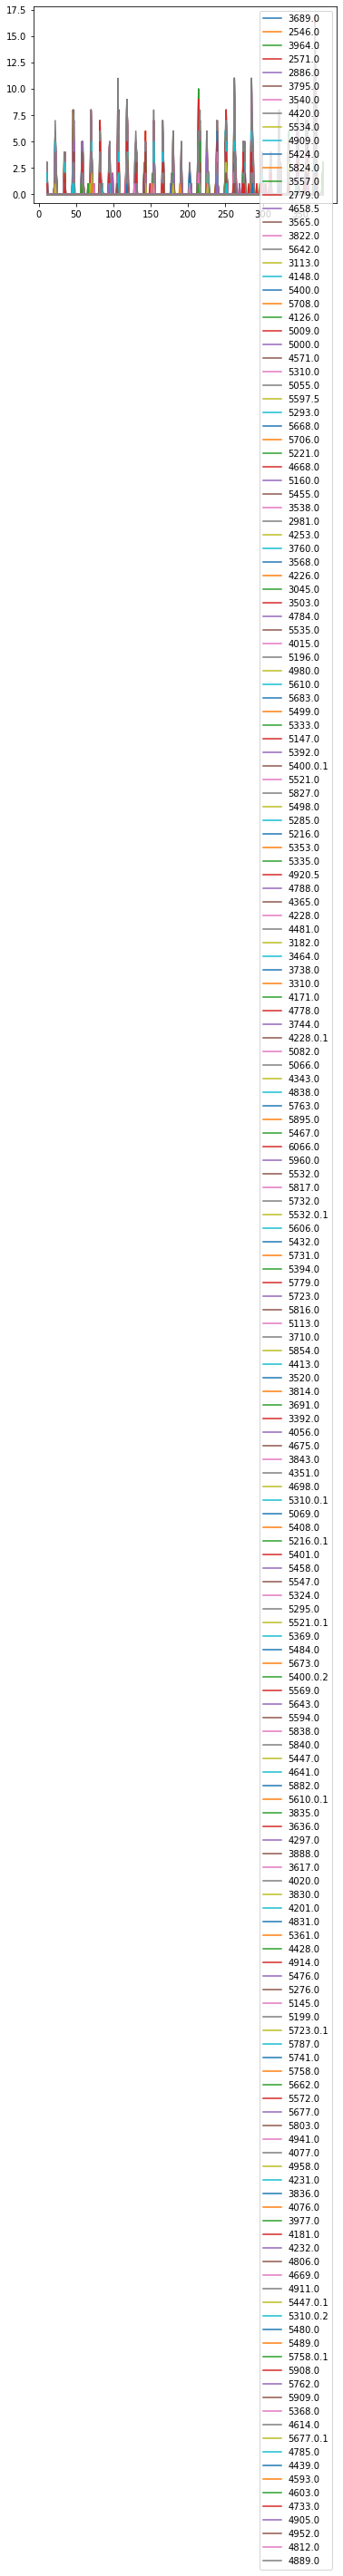

In [135]:
dfspot5_df.drop(['D', 'D_year', 'D_month'], axis = 1).plot()

In [136]:
testdf = pd.read_csv('/Users/varyabazilova/Desktop/paper2/202406_modelruns/30years/2025Jan_output/SL_daily/output_30percent/mustang_monthly_dfs_count_30percent_landcover1.csv', index_col=0)


# testdf.drop(['D', 'D_year', 'D_month'], axis = 1).plot()
testdf = filter_by_date(testdf)
testdf = prepare_dfcount(testdf)
# testdf

# testdf

In [137]:
testdf.id.unique().shape

(69748,)

In [138]:
dfspot5.id.unique().shape

(69748,)

In [139]:

# # Base directory where all output_Xpercent folders are located
# base_directory = "/Users/varyabazilova/Desktop/paper2/202406_modelruns/30years/2025Jan_output/SL_daily/"

# # Use glob to find all relevant files in output_XXpercent folders
# file_pattern = f"{base_directory}/output_*/mustang_monthly_dfs_count_*_landcover{landcover_idx}.csv"
# files = glob.glob(file_pattern)
# print(files)



In [168]:
import glob
import pandas as pd
import re

landcover_idx = 5
method = 'daily'

# Base directory where all output_Xpercent folders are located
base_directory = f"/Users/varyabazilova/Desktop/paper2/202406_modelruns/30years/2025Jan_output/SL_{method}/"

# Use glob to find all relevant files in output_XXpercent folders
file_pattern = f"{base_directory}/output_*/{location}_monthly_dfs_count_*_landcover{landcover_idx}.csv"
files = glob.glob(file_pattern)

dfs = []

# Loop through the files and process them
for file in files:
    # Extract the percentile from the folder name
    percentile = re.search(r'output_(\d+percent)', file).group(1)
    
    # Extract the landcover number from the file name
    landcover_number = re.search(r'landcover(\d+)', file).group(1)
    print(landcover_number)
    print(file)
    # Read the file into a DataFrame
    df = pd.read_csv(file, index_col=0).fillna(0)
    df = filter_by_date(df)

    # Apply your processing function
    processed_df = prepare_dfcount(df)
    
    # Rename the 'dfs_count' column to include percentile and landcover number
    processed_df = processed_df.rename(columns={'dfs_count': f'dfs_count_{percentile}'})
    # Append to the list
    dfs.append(processed_df)

merge_on = ['year', 'month', 'elevation', 'elevation_bin', 'id']
# merge_on = ['id']
dfspot_column = 'dfs_count'

if landcover_idx == 1:
    dfspot = dfspot1
if landcover_idx == 2:
    dfspot = dfspot2
if landcover_idx == 3:
    dfspot = dfspot3
if landcover_idx == 4:
    dfspot = dfspot4
if landcover_idx == 5:
    dfspot = dfspot5


dfmerged = merge_landcover_dfs(dfs, dfspot, merge_on, dfspot_column)
dffloods = calculate_floods(dfmerged)


outpath = '/Users/varyabazilova/Desktop/paper2/202406_modelruns/30years/2025Jan_output/df_vs_floods/mustang_test/'
dffloods.to_csv(outpath + f'{location}_df_vs_floods_{method}_landcover{landcover_idx}.csv')


5
/Users/varyabazilova/Desktop/paper2/202406_modelruns/30years/2025Jan_output/SL_daily/output_30percent/mustang_monthly_dfs_count_30percent_landcover5.csv
5
/Users/varyabazilova/Desktop/paper2/202406_modelruns/30years/2025Jan_output/SL_daily/output_20percent/mustang_monthly_dfs_count_20percent_landcover5.csv
5
/Users/varyabazilova/Desktop/paper2/202406_modelruns/30years/2025Jan_output/SL_daily/output_60percent/mustang_monthly_dfs_count_60percent_landcover5.csv
5
/Users/varyabazilova/Desktop/paper2/202406_modelruns/30years/2025Jan_output/SL_daily/output_40percent/mustang_monthly_dfs_count_40percent_landcover5.csv
5
/Users/varyabazilova/Desktop/paper2/202406_modelruns/30years/2025Jan_output/SL_daily/output_50percent/mustang_monthly_dfs_count_50percent_landcover5.csv


In [98]:

# dffloods.dfspot_count.plot()

In [99]:
dffloods

Index(['id', 'dfs_count_30percent', 'dfs_count_20percent',
       'dfs_count_60percent', 'dfs_count_40percent', 'dfs_count_50percent',
       'dfspot_count', 'ffs_count_60', 'ffs_count_50', 'ffs_count_40',
       'ffs_count_30', 'ffs_count_20'],
      dtype='object')

<AxesSubplot:>

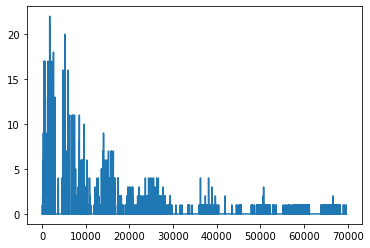

In [141]:
dffloods.ffs_count_40.plot()

<AxesSubplot:>

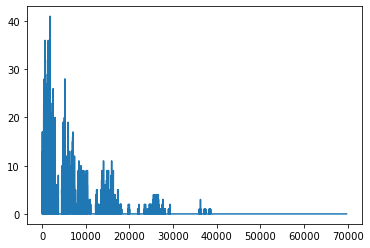

In [77]:
dffloods.dfs_count_60percent.plot()

<AxesSubplot:>

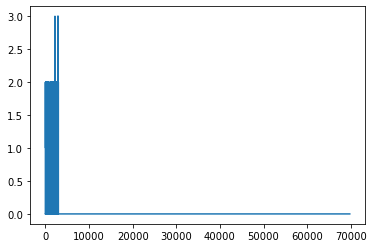

In [78]:
dffloods.dfspot_count.plot()

In [81]:
dffloods.id.unique().shape

(69748,)

In [ ]:
# 2 actual dfs 


In [ ]:
test = pd.read_csv('/Users/varyabazilova/Desktop/paper2/202406_modelruns/30years/2025Jan_output/df_vs_floods/mustang_test/mustang_df_vs_floods_once_landcover1.csv', index_col = 0).fillna(0)
test.columns


In [ ]:
test.ffs_count_20.plot()

In [ ]:
# dfmerged.dfspot_count.

In [ ]:
dfspot5.dfs_count.plot()

In [ ]:
dfspot4_df

In [ ]:
dfspot1_df.loc[:, (dfspot4_df != 0).any(axis=0)]

In [108]:
test = pd.read_csv('/Volumes/T7 Shield/202409_paper2_modelruns/30years/SL_once/3landcover_30percent/mustang_climate_cut/25a/Sediment.out')

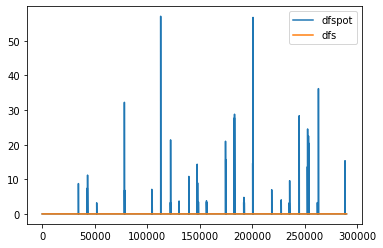

In [111]:
test.dfspot.plot(label = 'dfspot')
test.dfs.plot(label = 'dfs')

plt.legend()

<AxesSubplot:>

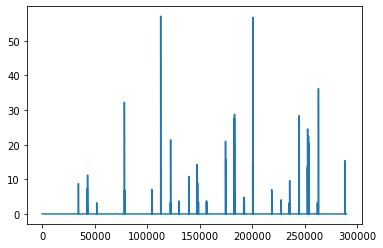

In [113]:
(test.dfspot - test.dfs).plot()